In [1]:
###############################################################################
### A.3: Final Report: SOTU
###############################################################################

In [2]:
###############################################################################
### Load Libraries
###############################################################################

import re,string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# import nltk.download
# from nltk.download import stopwords

import nltk
nltk.download('stopwords')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.manifold import MDS

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold

import pandas as pd
import os

from gensim.models import Word2Vec,LdaMulticore, TfidfModel
from gensim import corpora

from gensim.models.doc2vec import Doc2Vec, TaggedDocument

import numpy as np

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aliagowani/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Functionality to turn stemming on or off
STEMMING = False
NGRAM_LENGTH = 2

In [4]:
###############################################################################
### Function to process documents
###############################################################################

def clean_doc(doc): 
    #split document into individual words
    tokens=doc.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 4]
    #lowercase all words
    tokens = [word.lower() for word in tokens]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]         
    # word stemming    
    if STEMMING:
        ps=PorterStemmer()
        tokens=[ps.stem(word) for word in tokens]
    return tokens

In [5]:
###############################################################################
#   Functions to label encoding
###############################################################################

def One_Hot(variable):
    LE=LabelEncoder()
    LE.fit(variable)
    Label1=LE.transform(variable)
    OHE=OneHotEncoder()
    labels=OHE.fit_transform(Label1.reshape(-1,1)).toarray()
    return labels, LE, OHE

In [6]:
###############################################################################
### Read sotu_corpus.csv file from github
###############################################################################

# read in class corpus csv into python
data = pd.read_csv("https://raw.githubusercontent.com/ksenluu/NU_453_NLP/master/sotu_corpus_small.csv?token=AMLWIYTCDZY4HRVD6CSYNOC6KFYEO")

In [7]:
# new data frame with split value columns 
new = data["DSI_Title"].str.split("_", n = 1, expand = True) 
  
# making separate President_Name column from new data frame 
data["President_Name"] = new[0] 
  
# making separate Year_SOTU column from new data frame 
data["Year_SOTU"] = new[1] 
  
new = data["Year_SOTU"].str.split(".", n = 1, expand = True) 
data["Year_SOTU"] = new[0] 

# df display 
data.head(5) 

,Unnamed: 0,DSI_Title,Text,President_Name,Year_SOTU
0,0,Reagan_1982.txt,"Mr. Speaker, Mr. President, distinguished Memb...",Reagan,1982
1,1,Wilson_1914.txt,GENTLEMEN OF THE CONGRESS: The session upon w...,Wilson,1914
2,2,Madison_1814.txt,Fellow-Citizens of the Senate and House of Rep...,Madison,1814
3,3,Johnson_1969.txt,"Mr. Speaker, Mr. President, Members of the Con...",Johnson,1969
4,4,Hoover_1930.txt,To the Senate and House of Representatives: I...,Hoover,1930


In [8]:
###############################################################################
### Processing text into lists
###############################################################################

# create empty list to store text documents titles
titles=[]

#for loop which appends the DSI title to the titles list
for i in range(0,len(data)):
    temp_text=data['DSI_Title'].iloc[i]
    titles.append(temp_text)

# create empty list to store text documents
text_body=[]

# for loop which appends the text to the text_body list
for i in range(0,len(data)):
    temp_text=data['Text'].iloc[i]
    text_body.append(temp_text)

# Note: the text_body is the unprocessed list of documents read directly form the csv.

# empty list to store processed documents
processed_text=[]
#for loop to process the text to the processed_text list
for i in text_body:
    text=clean_doc(i)
    processed_text.append(text)

In [9]:
###############################################################################
### Note: the processed_text is the PROCESSED list of documents read directly  
### form the csv.  Note the list of words is separated by commas.
###############################################################################

# stitch back together individual words to reform body of text
final_processed_text=[]

for i in processed_text:
    temp_DSI=i[0]
    for k in range(1,len(i)):
        temp_DSI=temp_DSI+' '+i[k]
    final_processed_text.append(temp_DSI)

In [10]:
###############################################################################
### Sklearn TFIDF 
###############################################################################

# note the ngram_range will allow you to include multiple words within the TFIDF matrix
# Call Tfidf Vectorizer
Tfidf=TfidfVectorizer(ngram_range=(1,3))

#fit the vectorizer using final processed documents.  The vectorizer requires the 
#stiched back together document.
TFIDF_matrix=Tfidf.fit_transform(final_processed_text)

#creating datafram from TFIDF Matrix
matrix=pd.DataFrame(TFIDF_matrix.toarray(), columns=Tfidf.get_feature_names(), index=titles)

In [11]:
# Verify TFIDF_Matrix has been created.

matrix.head(5)

,aaron,aaron associates,aaron associates measures,abandon,abandon blessings,abandon blessings distant,abandon cause,abandon cause liberty,abandon conquest,abandon conquest nature,...,zones bring,zones bring inner,zones broad,zones broad range,zones could,zones could birthday,zones means,zones means tenant,zones together,zones together theres
Reagan_1982.txt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.013268,0.013268,0.0,0.0,0.0,0.0,0.0,0.0
Wilson_1914.txt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
Madison_1814.txt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
Johnson_1969.txt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
Hoover_1930.txt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
# Get unique names of President_Name to ensure BushW and BusHW were enetered correctly.
data['President_Name'].unique()

array(['Reagan', 'Wilson', 'Madison', 'Johnson', 'Hoover', 'Roosevelt',
       'Truman', 'Kennedy', 'Jefferson', 'Monroe', 'Trump', 'Eisenhower',
       'Obama', 'Adams', 'BushHW', 'Cleveland', 'Grant', 'Washington',
       'Ford', 'BushW', 'Nixon', 'Carter', 'Arthur'], dtype=object)

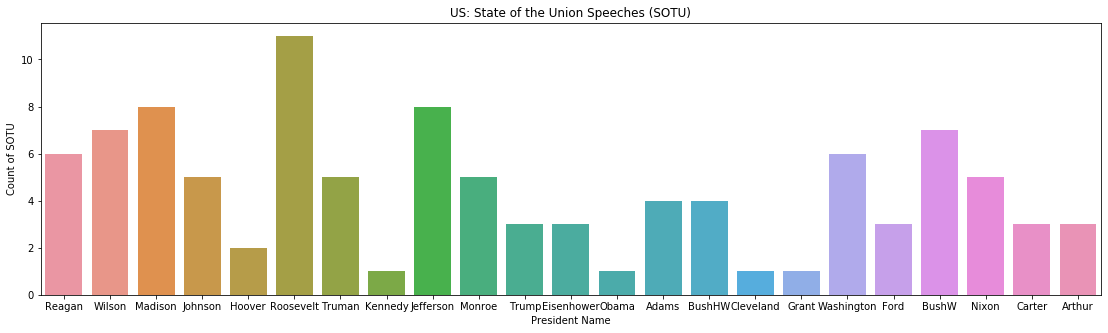

In [18]:
import seaborn as sns

# sns.set(style="darkgrid")

plt.subplots(figsize=(19,5))
ax = sns.countplot(x="President_Name", data=data)
# plt.savefig("plot-president_name.pdf", bbox_inches = 'tight', dpi=None, facecolor='w', edgecolor='b', orientation='portrait', papertype=None, format=None, pad_inches=0.25)
plt.xlabel('President Name')
plt.ylabel('Count of SOTU')
plt.title('US: State of the Union Speeches (SOTU)')
plt.show()